Text Classification with RNN and its Variants

Mounting Google Drive and Loading Dataset

In [1]:
# Import necessary libraries
import zipfile
import pandas as pd

df = pd.read_csv('sarcastic_headlines.csv')

# Display first few rows to verify
print(df.head())
print("\nDataset shape:", df.shape)
print("\nClass distribution:\n", df['is_sarcastic'].value_counts())

                                            headline  is_sarcastic
0  thirtysomething scientists unveil doomsday clo...             1
1  dem rep. totally nails why congress is falling...             0
2  eat your veggies: 9 deliciously different recipes             0
3  inclement weather prevents liar from getting t...             1
4  mother comes pretty close to using word 'strea...             1

Dataset shape: (28619, 2)

Class distribution:
 is_sarcastic
0    14985
1    13634
Name: count, dtype: int64


 Text Preprocessing and Cleaning

In [2]:
# Import necessary libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download all required NLTK data with error handling
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Additional download for punkt_tab if needed
try:
    nltk.data.find('tokenizers/punkt_tab/english')
except LookupError:
    try:
        nltk.download('punkt_tab')
    except:
        print("punkt_tab not available directly, using alternative approach")
        nltk.download('punkt')  # This should include the required tables

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a more robust cleaning function
def clean_text(text):
    try:
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|\#\w+', '', text)

        # Remove numbers and special characters (keep apostrophes for contractions)
        text = re.sub(r"[^a-zA-Z'\s]", '', text)

        # Handle common contractions
        contractions = {
            "don't": "do not",
            "can't": "cannot",
            "won't": "will not",
            "it's": "it is",
            "i'm": "i am",
            "you're": "you are",
            "they're": "they are",
            "that's": "that is",
            "what's": "what is",
            "didn't": "did not"
        }

        for cont, expanded in contractions.items():
            text = text.replace(cont, expanded)

        # Tokenize the text with error handling
        try:
            tokens = word_tokenize(text)
        except:
            # Fallback simple tokenizer if punkt fails
            tokens = text.split()

        # Remove stopwords and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        # Join tokens back into string
        cleaned_text = ' '.join(tokens)

        return cleaned_text

    except Exception as e:
        print(f"Error processing text: {text}. Error: {str(e)}")
        return ""  # Return empty string for problematic cases

# Apply cleaning function to the headlines with progress bar
from tqdm import tqdm
tqdm.pandas()

print("Cleaning headlines...")
df['cleaned_headline'] = df['headline'].progress_apply(clean_text)

# Display cleaned data
print("\nOriginal headline:", df['headline'].iloc[0])
print("Cleaned headline:", df['cleaned_headline'].iloc[0])
print("\nSample cleaned data:\n", df[['headline', 'cleaned_headline']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cleaning headlines...


100%|██████████| 28619/28619 [00:21<00:00, 1322.77it/s]


Original headline: thirtysomething scientists unveil doomsday clock of hair loss
Cleaned headline: thirtysomething scientist unveil doomsday clock hair loss

Sample cleaned data:
                                             headline  \
0  thirtysomething scientists unveil doomsday clo...   
1  dem rep. totally nails why congress is falling...   
2  eat your veggies: 9 deliciously different recipes   
3  inclement weather prevents liar from getting t...   
4  mother comes pretty close to using word 'strea...   

                                    cleaned_headline  
0  thirtysomething scientist unveil doomsday cloc...  
1  dem rep totally nail congress falling short ge...  
2            eat veggie deliciously different recipe  
3       inclement weather prevents liar getting work  
4  mother come pretty close using word 'streaming...  


 Data Visualization

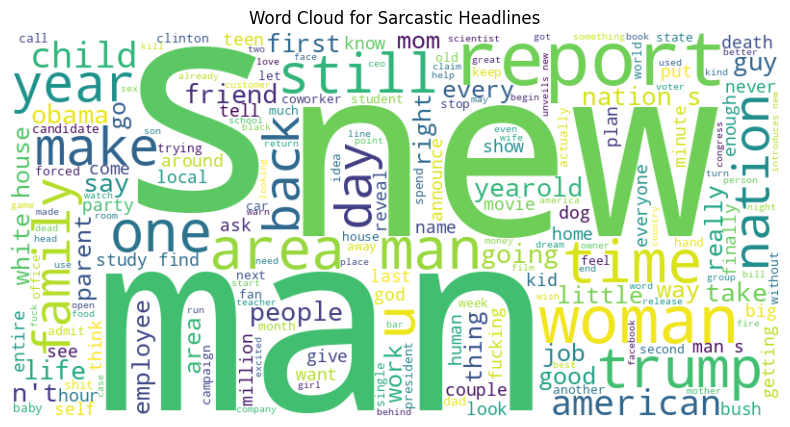

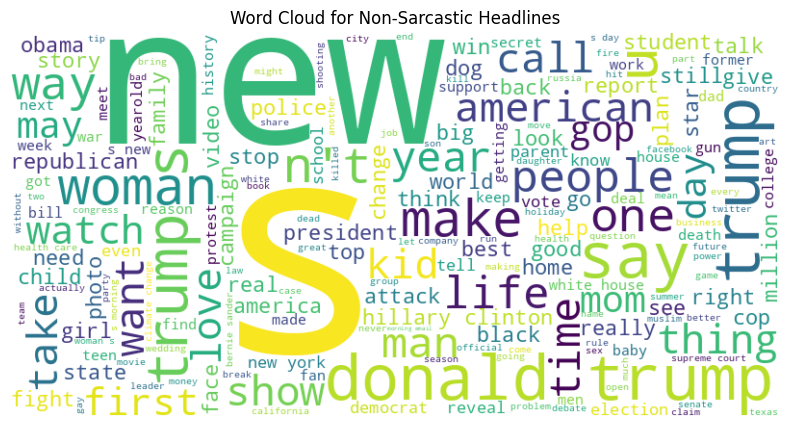

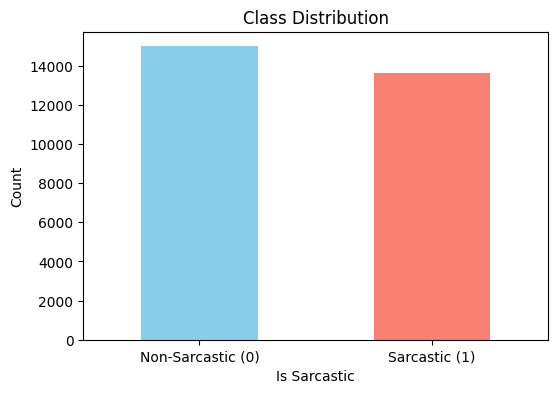

In [3]:
# Import visualization libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word cloud for sarcastic headlines
sarcastic_text = " ".join(df[df['is_sarcastic'] == 1]['cleaned_headline'])
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Word Cloud for Sarcastic Headlines')
plt.axis('off')
plt.show()

# Word cloud for non-sarcastic headlines
non_sarcastic_text = " ".join(df[df['is_sarcastic'] == 0]['cleaned_headline'])
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Word Cloud for Non-Sarcastic Headlines')
plt.axis('off')
plt.show()

# Plot class distribution
plt.figure(figsize=(6, 4))
df['is_sarcastic'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Is Sarcastic')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Sarcastic (0)', 'Sarcastic (1)'], rotation=0)
plt.show()

Tokenization and Sequence Padding

In [4]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Split data into training and testing sets
X = df['cleaned_headline']
y = df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization
max_words = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Calculate sequence lengths to determine optimal padding length
seq_lengths = [len(seq) for seq in train_sequences]
percentile = 95  # Using 95th percentile to determine padding length
max_len = int(np.percentile(seq_lengths, percentile))

# Padding sequences
X_train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

print("Vocabulary size:", len(tokenizer.word_index))
print("Maximum sequence length:", max_len)
print("\nSample padded sequence:\n", X_train_padded[0])

Vocabulary size: 23491
Maximum sequence length: 12

Sample padded sequence:
 [   4   62  192  685   26 4177   13 1382    0    0    0    0]


Model Building

Model 1: Simple RNN with Trainable Embedding

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 128)           1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,292,417
Trainable params: 1,292,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
322/322 [==============================] - 12s 28ms/step - loss: 0.4860 - accuracy: 0.7591 - val_loss: 0.4213 - val_accuracy: 0.8083
Epoch 2/10
322/322 [==============================] - 10s 30ms/step - loss: 0.2267 - accuracy: 0.9107 - val_loss: 0.4771 - val_accuracy: 0.8057
Epoch 3/10
322/322 [==

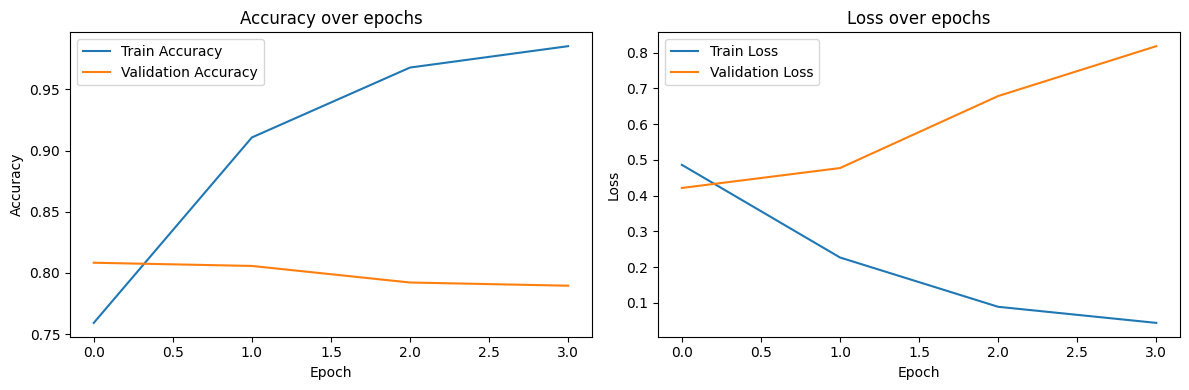

179/179 [==============================] - 1s 5ms/step - loss: 0.4099 - accuracy: 0.8094

Test Accuracy: 80.94%


In [5]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Model parameters
embedding_dim = 128
rnn_units = 64

# Build the model
model1 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(rnn_units, return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Compile the model
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model1.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history1 = model1.fit(X_train_padded, y_train,
                     epochs=10,
                     batch_size=64,
                     validation_split=0.1,
                     callbacks=[early_stopping])

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1)

# Evaluate the model
loss, accuracy = model1.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

Model 2: LSTM with Trainable Embedding

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 12, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
322/322 [==============================] - 17s 43ms/step - loss: 0.4919 - accuracy: 0.7511 - val_loss: 0.4365 - val_accuracy: 0.7895
Epoch 2/10
322/322 [==============================] - 14s 43ms/step - loss: 0.3116 - accuracy: 0.8667 - val_loss: 0.4385 - val_accuracy: 0.7983
Epoch 3/10
322/322 [

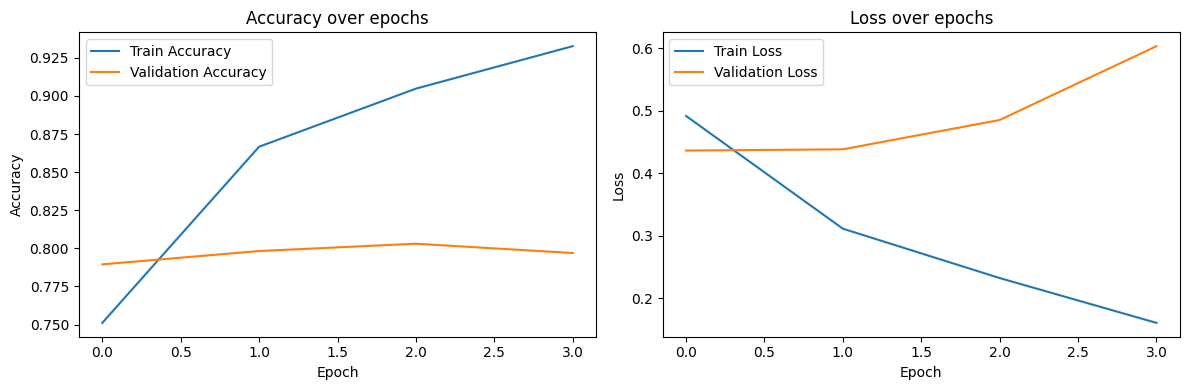

179/179 [==============================] - 1s 6ms/step - loss: 0.4265 - accuracy: 0.7991

Test Accuracy: 79.91%


In [6]:
# Import LSTM layer
from tensorflow.keras.layers import LSTM

# Model parameters (same embedding dimension as before)
lstm_units = 64

# Build the model
model2 = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(lstm_units, return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model2.summary()

# Train the model
history2 = model2.fit(X_train_padded, y_train,
                     epochs=10,
                     batch_size=64,
                     validation_split=0.1,
                     callbacks=[early_stopping])

# Plot training history
plot_history(history2)

# Evaluate the model
loss, accuracy = model2.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

Model 3: LSTM with Pretrained Word2Vec Embeddings

In [7]:
# First, uninstall and install specific versions
!pip uninstall -y gensim scipy numpy
!pip install gensim==4.3.2 scipy==1.10.1 numpy==1.23.5 tensorflow==2.12.0

# Now force the correct import order and patch the triu import
import sys
import numpy as np
import scipy
import scipy.linalg

# Monkey-patch the triu import if needed
if not hasattr(scipy.linalg, 'triu'):
    from scipy.linalg.basic import triu
    scipy.linalg.triu = triu

# Now import gensim
import gensim
import tensorflow as tf

# Verify versions
print("NumPy:", np.__version__)       # Should be 1.23.5
print("SciPy:", scipy.__version__)    # Should be 1.10.1
print("Gensim:", gensim.__version__)  # Should be 4.3.2
print("TensorFlow:", tf.__version__)  # Should be 2.12.0

# Verify gensim is working
print("Gensim test:", gensim.__version__)

Found existing installation: gensim 4.3.2
Uninstalling gensim-4.3.2:
  Successfully uninstalled gensim-4.3.2
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all 

NumPy: 1.23.5
SciPy: 1.10.1
Gensim: 4.3.2
TensorFlow: 2.12.0
Gensim test: 4.3.2


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 12, 300)           3000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,093,505
Trainable params: 93,505
Non-trainable params: 3,000,000
_________________________________________________________________
Epoch 1/10
322/322 [==============================] - 22s 51ms/step - loss: 0.5420 - accuracy: 0.7202 - val_loss: 0.4808 - val_accuracy: 0.7681
Epoch 2/10
322/322 [==============================] - 16s 49ms/step - lo

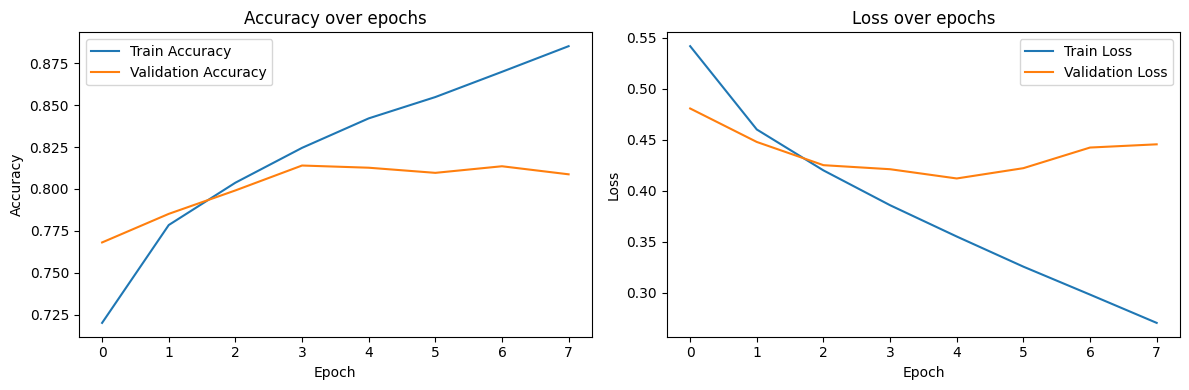

179/179 [==============================] - 1s 7ms/step - loss: 0.4157 - accuracy: 0.8077

Test Accuracy: 80.77%


In [8]:
# Download pretrained Word2Vec embeddings
import gensim.downloader as api

# Load Google's Word2Vec embeddings
word2vec_model = api.load('word2vec-google-news-300')

# Create embedding matrix
embedding_dim = 300  # Word2Vec vectors are 300-dimensional
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

# Build the model with pretrained embeddings
model3 = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),  # Keep embeddings fixed
    LSTM(lstm_units, return_sequences=False),
    Dense(1, activation='sigmoid')
])

# Compile the model
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model3.summary()

# Train the model
history3 = model3.fit(X_train_padded, y_train,
                     epochs=10,
                     batch_size=64,
                     validation_split=0.1,
                     callbacks=[early_stopping])

# Plot training history
plot_history(history3)

# Evaluate the model
loss, accuracy = model3.evaluate(X_test_padded, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

8. Model Evaluation and Comparison


Evaluating Model 1 (Simple RNN):
179/179 [==============================] - 1s 4ms/step


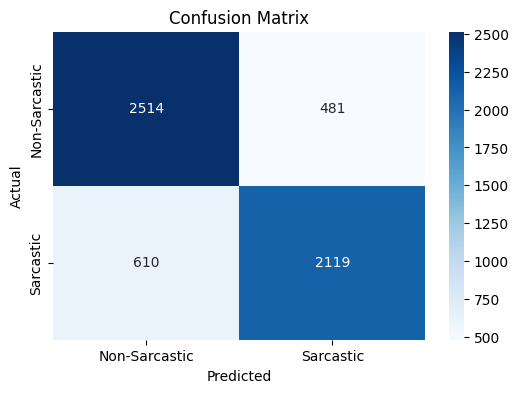


Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.80      0.84      0.82      2995
    Sarcastic       0.81      0.78      0.80      2729

     accuracy                           0.81      5724
    macro avg       0.81      0.81      0.81      5724
 weighted avg       0.81      0.81      0.81      5724


Evaluating Model 2 (LSTM):
179/179 [==============================] - 2s 6ms/step


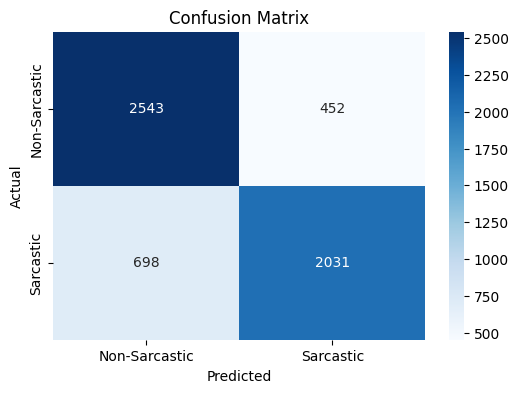


Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.78      0.85      0.82      2995
    Sarcastic       0.82      0.74      0.78      2729

     accuracy                           0.80      5724
    macro avg       0.80      0.80      0.80      5724
 weighted avg       0.80      0.80      0.80      5724


Evaluating Model 3 (LSTM with Word2Vec):
179/179 [==============================] - 4s 14ms/step


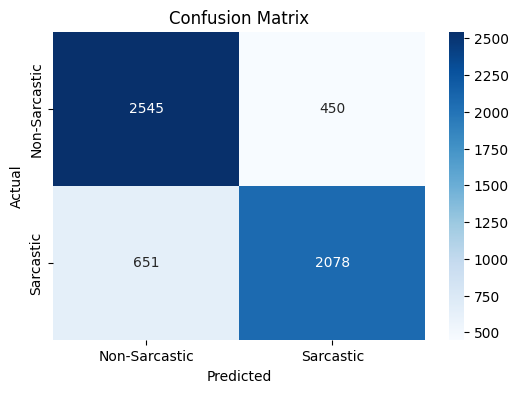


Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.80      0.85      0.82      2995
    Sarcastic       0.82      0.76      0.79      2729

     accuracy                           0.81      5724
    macro avg       0.81      0.81      0.81      5724
 weighted avg       0.81      0.81      0.81      5724

179/179 [==============================] - 4s 20ms/step - loss: 0.4157 - accuracy: 0.8077


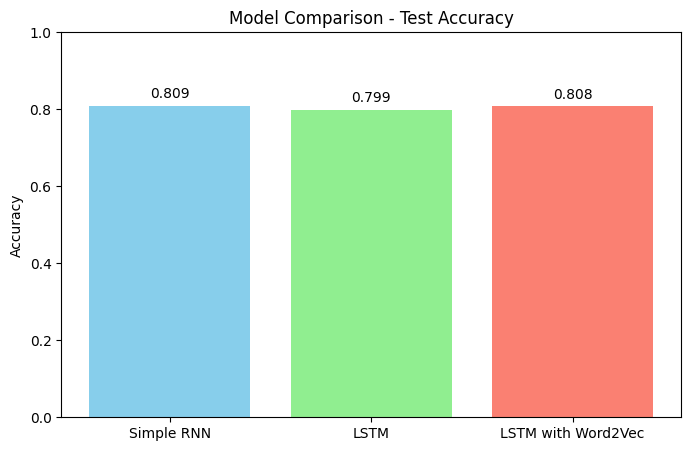

In [9]:
# Import evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to evaluate and plot metrics
def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Sarcastic', 'Sarcastic'],
                yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

# Evaluate all models
print("\nEvaluating Model 1 (Simple RNN):")
evaluate_model(model1, X_test_padded, y_test)

print("\nEvaluating Model 2 (LSTM):")
evaluate_model(model2, X_test_padded, y_test)

print("\nEvaluating Model 3 (LSTM with Word2Vec):")
evaluate_model(model3, X_test_padded, y_test)

# Compare model accuracies
model_names = ['Simple RNN', 'LSTM', 'LSTM with Word2Vec']
accuracies = [model1.evaluate(X_test_padded, y_test)[1],
              model2.evaluate(X_test_padded, y_test)[1],
              model3.evaluate(X_test_padded, y_test)[1]]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.3f}", ha='center')
plt.show()

Streamlit Deployment

In [10]:
# After training your model in Colab, add these lines:

# 1. Save the max_len value in the tokenizer pickle
import pickle
tokenizer.max_len = max_len  # Store max_len in the tokenizer object

# 2. Save tokenizer (protocol=4 for compatibility)
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=4)

# 3. Save model (optimized for deployment)
model2.save('best_model.h5', include_optimizer=False)

# Verify model input shape
print("Model expects input shape:", model2.input_shape)  # Should match your max_len

Model expects input shape: (None, 12)


In [11]:
from google.colab import files
files.download('tokenizer.pkl')
files.download('best_model.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Install Gradio (only once)
!pip install gradio --quiet

import gradio as gr
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the tokenizer (make sure tokenizer.pkl exists)
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load the trained Keras model (make sure best_model.h5 exists)
model = load_model('best_model.h5')

# Define max sequence length used during training
MAX_LEN = 100  # Change this to the actual maxlen used when training

# Optional: Label mapping (update as per your dataset)
label_map = {
    0: "Not sarcastic",
    1: "Neutral",
    2: "Sarcastic"
}

# Set the correct input length used during training
MAX_LEN = 12  # ✅ Fix: Match the input length the model expects

def predict_tweet(text):
    try:
        if not text.strip():
            return "Please enter some text."

        # Convert input text to sequence
        sequence = tokenizer.texts_to_sequences([text])
        if not sequence or not any(sequence[0]):
            return "Input text is too short or contains unknown words."

        padded = pad_sequences(sequence, maxlen=MAX_LEN)

        # Make prediction
        prediction = model.predict(padded)

        print("Prediction raw output:", prediction)

        # Case 1: Binary classification (sigmoid)
        if prediction.shape == (1, 1):
            score = prediction[0][0]
            label = "Sarcastic" if score >= 0.5 else "Not sarcastic"
            return f"Prediction: {label} (Confidence: {score:.2f})"

        # Case 2: Multiclass classification (softmax)
        elif len(prediction.shape) == 2:
            probs = prediction[0]
            predicted_class = probs.argmax()
            confidence = probs[predicted_class]

            label_map = {0: "not sarcastic", 1: "Neutral", 2: "sarcastic"}  # Adjust as needed
            label = label_map.get(predicted_class, f"Class {predicted_class}")

            return f"Prediction: {label} (Confidence: {confidence:.2f})"

        else:
            return f"Unexpected prediction shape: {prediction.shape}"

    except Exception as e:
        print("Error during prediction:", e)
        return f"An error occurred: {str(e)}"



# Create Gradio interface
interface = gr.Interface(
    fn=predict_tweet,
    inputs=gr.Textbox(lines=2, placeholder="Enter a tweet here..."),
    outputs="text",
    title="Tweet Sentiment Predictor",
    description="Enter a tweet to classify its sentiment in real time."
)

# Launch the interface
interface.launch(share=True)  # 'share=True' creates a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ef8214ac13de5d9c71.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
